In [3]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, Image

In [20]:
K = np.array([
  [0.000000,0.000000,0.689184,0.000000,0.000000,0.000000,0.000000,0.000000,0.715675,0.000000,0.000000,0.000000],
  [0.000039,-0.000787,0.000000,0.008870,0.000443,0.000036,0.000058,-0.001153,0.000000,0.000874,0.000044,0.000036],
  [0.000787,-0.000039,0.000000,0.000443,0.008870,0.000090,0.001153,-0.000058,0.000000,0.000044,0.000874,0.000090],
  [0.000085,-0.000034,0.000000,0.000385,0.000962,0.001458,0.000125,-0.000050,0.000000,0.000038,0.000095,0.001472],
])

In [27]:
import logging
import time
import numpy as np

import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncLogger import SyncLogger

URI = f'radio://0/1/2M'

# Only output errors from the logging framework
logging.basicConfig(level=logging.ERROR)

log_keys = ['e_x',
            'e_y',
            'e_roll',
            'e_pitch',]

other_log_keys = []

if __name__ == '__main__':
    cflib.crtp.init_drivers(enable_debug_driver=False)

    with SyncCrazyflie(URI, cf=Crazyflie(rw_cache='./cache')) as scf:
        cf = scf.cf

        lg_stab = LogConfig(name='LQR', period_in_ms=10)
        lg_data = {}

        for key in log_keys:
            lg_stab.add_variable('ctrlLQR.' + key, 'float')
            lg_data[key] = []

        for key in other_log_keys:
            lg_stab.add_variable( key, 'float')
            lg_data[key.split('.')[1]] = []

        for i in range(4):
            for j in range(12):
                cf.param.set_value(f'ctrlLQR.k{i + 1}{j + 1}', '{:.10f}'.format(K[i, j]))

        cf.param.set_value('kalman.resetEstimation', '1')
        time.sleep(0.1)
        cf.param.set_value('kalman.resetEstimation', '0')
        time.sleep(2)
        print('Reset Kalman filter.')
            
        print('Switching to LQR!')
        cf.param.set_value('stabilizer.controller', '5')

        print('Taking off!')

        for y in range(10):
            cf.commander.send_position_setpoint(0, 0, y / 25, 0)
            #cf.commander.send_stop_setpoint()
            time.sleep(0.1)

        with SyncLogger(scf, lg_stab) as logger:
            t_start = time.time()
            entry_count = 0

            for log_entry in logger:
                cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
                for key, value in log_entry[1].items():
                    lg_data[key.split('.')[1]].append(value)

                entry_count += 1

                if time.time() - t_start > 6:
                    break

        print('Saving data...')
        for key in lg_data.keys():
            lg_data[key] = np.array(lg_data[key])

        np.savez('quad_data/quad_traj', **lg_data)

        for y in range(10):
            cf.commander.send_position_setpoint(0, 0, (10 - y) / 25, 0)
            time.sleep(0.15)

        for i in range(10):
            cf.commander.send_stop_setpoint()
            time.sleep(0.1)

print('Done!') 

Reset Kalman filter.
Switching to LQR!
Taking off!
Saving data...
Done!


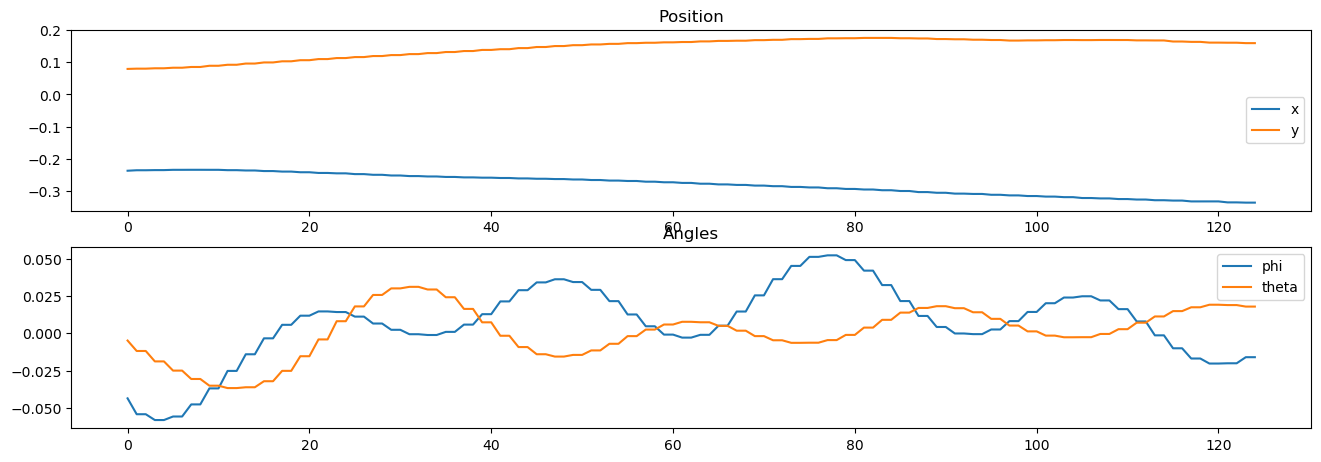

In [28]:
import os

if os.path.isfile('quad_data/quad_traj.npz'):
    npzfile = np.load('quad_data/quad_traj.npz')

    plt.rcParams["figure.figsize"] = (16,8)
    fig = plt.figure()

    ax = fig.add_subplot(311, title='Position')
    ax.plot(npzfile['e_x'][:125], label='x')
    ax.plot(npzfile['e_y'][:125], label='y')
    ax.legend()

    ax = fig.add_subplot(312, title='Angles')
    ax.plot(npzfile['e_roll'][:125], label='phi')
    ax.plot(npzfile['e_pitch'][:125], label='theta')
    ax.legend()

    # ax = fig.add_subplot(313, title='Moments')
    # ax.plot(npzfile['u2_pwm'][:125] / (2 ** 15), label='M1')
    # ax.plot(npzfile['u3_pwm'][:125] / (2 ** 15), label='M2')
    # ax.legend()
else:
    print('No flight data found.')